In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from helpers import splitting, get_Xy, fit_models_get_CV_scores
import random

# Data loading

Choose the type of data

In [13]:
X_w2v = pd.read_csv('TransformedData/X_w2v.csv')
y = pd.read_csv('TransformedData/y.csv')
y = pd.Series(y['condition_name'])

In [14]:
train, test = splitting(X_w2v, y)

/Users/mariannescoglio/Desktop/MA1/ML/ml-project-2-ml4health/helpers.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X_train, X_test, y_train, y_test = pd.DataFrame(), pd.DataFrame(), pd.Series(), pd.Series()
/Users/mariannescoglio/Desktop/MA1/ML/ml-project-2-ml4health/helpers.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X_train, X_test, y_train, y_test = pd.DataFrame(), pd.DataFrame(), pd.Series(), pd.Series()
/Users/mariannescoglio/Desktop/MA1/ML/ml-project-2-ml4health/helpers.py:207: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X_train_sub, X_test_sub, y_train_sub, y_test_sub = X_condition, pd.DataFrame(), y_condition, pd.

In [15]:
X_train, y_train = get_Xy(train)
X_test, y_test = get_Xy(test)

In [16]:
#fix a seed for reproducibility
seed=0
np.random.seed(0)
pd.np.random.seed(0)
random.seed(0)
#fix a score metric for f1
avg = 'weighted'

/var/folders/qp/pyvldkl53w97p1km8zjl72vr0000gn/T/ipykernel_91800/696029834.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  pd.np.random.seed(0)


# Test different classifiers

In [38]:
models = [
    LogisticRegression(random_state=seed),
    RandomForestClassifier(random_state=seed), 
    #GradientBoostingClassifier(random_state=seed), #takes a really long time to run
    AdaBoostClassifier(random_state=seed),
    DecisionTreeClassifier(random_state=seed),
    SVC(random_state=seed), 
    LinearSVC(random_state=seed),
    GaussianNB(),
]

In [ ]:
cv_scores_df = fit_models_get_CV_scores(
    models=models,
    X = X_train,
    y = y_train,
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed),
    scoring={
        "f1":"f1_weighted", 
        "accuracy":"accuracy",
        #"recall":"recall_weighted",
        #"precision":"precision_weighted"
    }
)
cv_scores_df

In [ ]:
mean_cv_scores_df = cv_scores_df.groupby("model").mean().sort_values(by="test_f1", ascending=False)
mean_cv_scores_df.to_csv('compare_classifiers')
mean_cv_scores_df

In [ ]:
plt.figure(figsize=(10, 10))
ax = sns.barplot(
    data=cv_scores_df.drop("fit_time", axis=1).melt(id_vars=['model', 'fold'], var_name='measurement', value_name='value'),
    x="value",
    y="model",
    hue="measurement",
    palette="colorblind",
    errcolor='lightgray'
)

for i in ax.containers:
    ax.bar_label(i)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)

plt.savefig('Compare models.png')
plt.show()

# Tune best classifiers

## Linear SVC

In [17]:
svc = LinearSVC(random_state=seed)

# Define the parameter grid to search
param_grid = {
    'C': np.logspace(-4, 4, 10),  # Regularization parameter
    'max_iter': [1000, 5000, 10000],  # Maximum number of iterations to converge
    'tol': [1e-4, 1e-3, 1e-2],  # Tolerance for stopping criteria
    'loss' : ['hinge', 'squared_hinge']
}

# Use F1 score as the scoring metric
scorer = make_scorer(f1_score, average=avg)

grid_search = GridSearchCV(svc, param_grid, scoring=scorer, cv=3, verbose=1, n_jobs=-1)

# # # Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print all scores for each combination of hyperparameters
cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print("Mean F1 Score: {:.3f}  Params: {}".format(mean_score, params))

#Print the best parameters and corresponding f1
print("\nBest parameters: ", grid_search.best_params_)
print("Best training F1 score: {:.3f}".format(grid_search.best_score_))

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test)
test_f1_score = f1_score(y_test, y_pred_test, average=avg)
print("Test F1 score of the best model: {:.3f}".format(test_f1_score))


Fitting 3 folds for each of 180 candidates, totalling 540 fits


/Users/mariannescoglio/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/Users/mariannescoglio/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/mariannescoglio/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/mariannescoglio/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/mariannescoglio/an

In [ ]:
'''
Fitting 3 folds for each of 180 candidates, totalling 540 fits

Mean F1 Score: 0.002  Params: {'C': 0.0001, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.0001}
Mean F1 Score: 0.002  Params: {'C': 0.0001, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.001}
Mean F1 Score: 0.002  Params: {'C': 0.0001, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.01}
Mean F1 Score: 0.002  Params: {'C': 0.0001, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.0001}
Mean F1 Score: 0.002  Params: {'C': 0.0001, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.001}
Mean F1 Score: 0.002  Params: {'C': 0.0001, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.01}
Mean F1 Score: 0.002  Params: {'C': 0.0001, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.0001}
Mean F1 Score: 0.002  Params: {'C': 0.0001, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.001}
Mean F1 Score: 0.002  Params: {'C': 0.0001, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.01}
Mean F1 Score: 0.004  Params: {'C': 0.0001, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.0001}
Mean F1 Score: 0.004  Params: {'C': 0.0001, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.001}
Mean F1 Score: 0.005  Params: {'C': 0.0001, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.01}
Mean F1 Score: 0.004  Params: {'C': 0.0001, 'loss': 'squared_hinge', 'max_iter': 5000, 'tol': 0.0001}
Mean F1 Score: 0.004  Params: {'C': 0.0001, 'loss': 'squared_hinge', 'max_iter': 5000, 'tol': 0.001}
Mean F1 Score: 0.005  Params: {'C': 0.0001, 'loss': 'squared_hinge', 'max_iter': 5000, 'tol': 0.01}
Mean F1 Score: 0.004  Params: {'C': 0.0001, 'loss': 'squared_hinge', 'max_iter': 10000, 'tol': 0.0001}
Mean F1 Score: 0.004  Params: {'C': 0.0001, 'loss': 'squared_hinge', 'max_iter': 10000, 'tol': 0.001}
Mean F1 Score: 0.005  Params: {'C': 0.0001, 'loss': 'squared_hinge', 'max_iter': 10000, 'tol': 0.01}
Mean F1 Score: 0.115  Params: {'C': 0.000774263682681127, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.0001}
Mean F1 Score: 0.113  Params: {'C': 0.000774263682681127, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.001}
Mean F1 Score: 0.113  Params: {'C': 0.000774263682681127, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.01}
Mean F1 Score: 0.115  Params: {'C': 0.000774263682681127, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.0001}
Mean F1 Score: 0.113  Params: {'C': 0.000774263682681127, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.001}
Mean F1 Score: 0.113  Params: {'C': 0.000774263682681127, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.01}
Mean F1 Score: 0.115  Params: {'C': 0.000774263682681127, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.0001}
Mean F1 Score: 0.113  Params: {'C': 0.000774263682681127, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.001}
Mean F1 Score: 0.113  Params: {'C': 0.000774263682681127, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.01}
Mean F1 Score: 0.039  Params: {'C': 0.000774263682681127, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.0001}
Mean F1 Score: 0.039  Params: {'C': 0.000774263682681127, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.001}
Mean F1 Score: 0.040  Params: {'C': 0.000774263682681127, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.01}
Mean F1 Score: 0.039  Params: {'C': 0.000774263682681127, 'loss': 'squared_hinge', 'max_iter': 5000, 'tol': 0.0001}
Mean F1 Score: 0.039  Params: {'C': 0.000774263682681127, 'loss': 'squared_hinge', 'max_iter': 5000, 'tol': 0.001}
Mean F1 Score: 0.040  Params: {'C': 0.000774263682681127, 'loss': 'squared_hinge', 'max_iter': 5000, 'tol': 0.01}
Mean F1 Score: 0.039  Params: {'C': 0.000774263682681127, 'loss': 'squared_hinge', 'max_iter': 10000, 'tol': 0.0001}
Mean F1 Score: 0.039  Params: {'C': 0.000774263682681127, 'loss': 'squared_hinge', 'max_iter': 10000, 'tol': 0.001}
Mean F1 Score: 0.040  Params: {'C': 0.000774263682681127, 'loss': 'squared_hinge', 'max_iter': 10000, 'tol': 0.01}
Mean F1 Score: 0.168  Params: {'C': 0.005994842503189409, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.0001}
Mean F1 Score: 0.167  Params: {'C': 0.005994842503189409, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.001}
Mean F1 Score: 0.166  Params: {'C': 0.005994842503189409, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.01}
Mean F1 Score: 0.168  Params: {'C': 0.005994842503189409, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.0001}
Mean F1 Score: 0.167  Params: {'C': 0.005994842503189409, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.001}
Mean F1 Score: 0.166  Params: {'C': 0.005994842503189409, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.01}
Mean F1 Score: 0.168  Params: {'C': 0.005994842503189409, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.0001}
Mean F1 Score: 0.167  Params: {'C': 0.005994842503189409, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.001}
Mean F1 Score: 0.166  Params: {'C': 0.005994842503189409, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.01}
Mean F1 Score: 0.135  Params: {'C': 0.005994842503189409, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.0001}
Mean F1 Score: 0.135  Params: {'C': 0.005994842503189409, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.001}
Mean F1 Score: 0.135  Params: {'C': 0.005994842503189409, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.01}
Mean F1 Score: 0.135  Params: {'C': 0.005994842503189409, 'loss': 'squared_hinge', 'max_iter': 5000, 'tol': 0.0001}
Mean F1 Score: 0.135  Params: {'C': 0.005994842503189409, 'loss': 'squared_hinge', 'max_iter': 5000, 'tol': 0.001}
Mean F1 Score: 0.135  Params: {'C': 0.005994842503189409, 'loss': 'squared_hinge', 'max_iter': 5000, 'tol': 0.01}
Mean F1 Score: 0.135  Params: {'C': 0.005994842503189409, 'loss': 'squared_hinge', 'max_iter': 10000, 'tol': 0.0001}
Mean F1 Score: 0.135  Params: {'C': 0.005994842503189409, 'loss': 'squared_hinge', 'max_iter': 10000, 'tol': 0.001}
Mean F1 Score: 0.135  Params: {'C': 0.005994842503189409, 'loss': 'squared_hinge', 'max_iter': 10000, 'tol': 0.01}
Mean F1 Score: 0.167  Params: {'C': 0.046415888336127774, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.0001}
Mean F1 Score: 0.168  Params: {'C': 0.046415888336127774, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.001}
Mean F1 Score: 0.168  Params: {'C': 0.046415888336127774, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.01}
Mean F1 Score: 0.167  Params: {'C': 0.046415888336127774, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.0001}
Mean F1 Score: 0.168  Params: {'C': 0.046415888336127774, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.001}
Mean F1 Score: 0.168  Params: {'C': 0.046415888336127774, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.01}
Mean F1 Score: 0.167  Params: {'C': 0.046415888336127774, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.0001}
Mean F1 Score: 0.168  Params: {'C': 0.046415888336127774, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.001}
Mean F1 Score: 0.168  Params: {'C': 0.046415888336127774, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.01}
Mean F1 Score: 0.168  Params: {'C': 0.046415888336127774, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.0001}
Mean F1 Score: 0.168  Params: {'C': 0.046415888336127774, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.001}
Mean F1 Score: 0.168  Params: {'C': 0.046415888336127774, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.01}
Mean F1 Score: 0.168  Params: {'C': 0.046415888336127774, 'loss': 'squared_hinge', 'max_iter': 5000, 'tol': 0.0001}
Mean F1 Score: 0.168  Params: {'C': 0.046415888336127774, 'loss': 'squared_hinge', 'max_iter': 5000, 'tol': 0.001}
Mean F1 Score: 0.168  Params: {'C': 0.046415888336127774, 'loss': 'squared_hinge', 'max_iter': 5000, 'tol': 0.01}
Mean F1 Score: 0.168  Params: {'C': 0.046415888336127774, 'loss': 'squared_hinge', 'max_iter': 10000, 'tol': 0.0001}
Mean F1 Score: 0.168  Params: {'C': 0.046415888336127774, 'loss': 'squared_hinge', 'max_iter': 10000, 'tol': 0.001}
Mean F1 Score: 0.168  Params: {'C': 0.046415888336127774, 'loss': 'squared_hinge', 'max_iter': 10000, 'tol': 0.01}
Mean F1 Score: 0.169  Params: {'C': 0.3593813663804626, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.0001}
Mean F1 Score: 0.169  Params: {'C': 0.3593813663804626, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.001}
Mean F1 Score: 0.171  Params: {'C': 0.3593813663804626, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.01}
Mean F1 Score: 0.169  Params: {'C': 0.3593813663804626, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.0001}
Mean F1 Score: 0.168  Params: {'C': 0.3593813663804626, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.001}
Mean F1 Score: 0.171  Params: {'C': 0.3593813663804626, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.01}
Mean F1 Score: 0.169  Params: {'C': 0.3593813663804626, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.0001}
Mean F1 Score: 0.168  Params: {'C': 0.3593813663804626, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.001}
Mean F1 Score: 0.171  Params: {'C': 0.3593813663804626, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.01}
Mean F1 Score: 0.162  Params: {'C': 0.3593813663804626, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.0001}
Mean F1 Score: 0.163  Params: {'C': 0.3593813663804626, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.001}
Mean F1 Score: 0.163  Params: {'C': 0.3593813663804626, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.01}
Mean F1 Score: 0.162  Params: {'C': 0.3593813663804626, 'loss': 'squared_hinge', 'max_iter': 5000, 'tol': 0.0001}
Mean F1 Score: 0.163  Params: {'C': 0.3593813663804626, 'loss': 'squared_hinge', 'max_iter': 5000, 'tol': 0.001}
Mean F1 Score: 0.163  Params: {'C': 0.3593813663804626, 'loss': 'squared_hinge', 'max_iter': 5000, 'tol': 0.01}
Mean F1 Score: 0.162  Params: {'C': 0.3593813663804626, 'loss': 'squared_hinge', 'max_iter': 10000, 'tol': 0.0001}
Mean F1 Score: 0.163  Params: {'C': 0.3593813663804626, 'loss': 'squared_hinge', 'max_iter': 10000, 'tol': 0.001}
Mean F1 Score: 0.163  Params: {'C': 0.3593813663804626, 'loss': 'squared_hinge', 'max_iter': 10000, 'tol': 0.01}
Mean F1 Score: 0.152  Params: {'C': 2.782559402207126, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.0001}
Mean F1 Score: 0.152  Params: {'C': 2.782559402207126, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.001}
Mean F1 Score: 0.153  Params: {'C': 2.782559402207126, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.01}
Mean F1 Score: 0.152  Params: {'C': 2.782559402207126, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.0001}
Mean F1 Score: 0.151  Params: {'C': 2.782559402207126, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.001}
Mean F1 Score: 0.153  Params: {'C': 2.782559402207126, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.01}
Mean F1 Score: 0.152  Params: {'C': 2.782559402207126, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.0001}
Mean F1 Score: 0.151  Params: {'C': 2.782559402207126, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.001}
Mean F1 Score: 0.153  Params: {'C': 2.782559402207126, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.01}
Mean F1 Score: 0.151  Params: {'C': 2.782559402207126, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.0001}
Mean F1 Score: 0.151  Params: {'C': 2.782559402207126, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.001}
Mean F1 Score: 0.152  Params: {'C': 2.782559402207126, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.01}
Mean F1 Score: 0.151  Params: {'C': 2.782559402207126, 'loss': 'squared_hinge', 'max_iter': 5000, 'tol': 0.0001}
Mean F1 Score: 0.151  Params: {'C': 2.782559402207126, 'loss': 'squared_hinge', 'max_iter': 5000, 'tol': 0.001}
Mean F1 Score: 0.152  Params: {'C': 2.782559402207126, 'loss': 'squared_hinge', 'max_iter': 5000, 'tol': 0.01}
Mean F1 Score: 0.151  Params: {'C': 2.782559402207126, 'loss': 'squared_hinge', 'max_iter': 10000, 'tol': 0.0001}
Mean F1 Score: 0.151  Params: {'C': 2.782559402207126, 'loss': 'squared_hinge', 'max_iter': 10000, 'tol': 0.001}
Mean F1 Score: 0.152  Params: {'C': 2.782559402207126, 'loss': 'squared_hinge', 'max_iter': 10000, 'tol': 0.01}
Mean F1 Score: 0.139  Params: {'C': 21.54434690031882, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.0001}
Mean F1 Score: 0.140  Params: {'C': 21.54434690031882, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.001}
Mean F1 Score: 0.140  Params: {'C': 21.54434690031882, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.01}
Mean F1 Score: 0.139  Params: {'C': 21.54434690031882, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.0001}
Mean F1 Score: 0.140  Params: {'C': 21.54434690031882, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.001}
Mean F1 Score: 0.140  Params: {'C': 21.54434690031882, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.01}
Mean F1 Score: 0.139  Params: {'C': 21.54434690031882, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.0001}
Mean F1 Score: 0.140  Params: {'C': 21.54434690031882, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.001}
Mean F1 Score: 0.140  Params: {'C': 21.54434690031882, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.01}
Mean F1 Score: 0.142  Params: {'C': 21.54434690031882, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.0001}
Mean F1 Score: 0.142  Params: {'C': 21.54434690031882, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.001}
Mean F1 Score: 0.143  Params: {'C': 21.54434690031882, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.01}
Mean F1 Score: 0.142  Params: {'C': 21.54434690031882, 'loss': 'squared_hinge', 'max_iter': 5000, 'tol': 0.0001}
Mean F1 Score: 0.142  Params: {'C': 21.54434690031882, 'loss': 'squared_hinge', 'max_iter': 5000, 'tol': 0.001}
Mean F1 Score: 0.143  Params: {'C': 21.54434690031882, 'loss': 'squared_hinge', 'max_iter': 5000, 'tol': 0.01}
Mean F1 Score: 0.142  Params: {'C': 21.54434690031882, 'loss': 'squared_hinge', 'max_iter': 10000, 'tol': 0.0001}
Mean F1 Score: 0.142  Params: {'C': 21.54434690031882, 'loss': 'squared_hinge', 'max_iter': 10000, 'tol': 0.001}
Mean F1 Score: 0.143  Params: {'C': 21.54434690031882, 'loss': 'squared_hinge', 'max_iter': 10000, 'tol': 0.01}
Mean F1 Score: 0.138  Params: {'C': 166.81005372000558, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.0001}
Mean F1 Score: 0.138  Params: {'C': 166.81005372000558, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.001}
Mean F1 Score: 0.139  Params: {'C': 166.81005372000558, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.01}
Mean F1 Score: 0.138  Params: {'C': 166.81005372000558, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.0001}
Mean F1 Score: 0.138  Params: {'C': 166.81005372000558, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.001}
Mean F1 Score: 0.139  Params: {'C': 166.81005372000558, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.01}
Mean F1 Score: 0.138  Params: {'C': 166.81005372000558, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.0001}
Mean F1 Score: 0.138  Params: {'C': 166.81005372000558, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.001}
Mean F1 Score: 0.139  Params: {'C': 166.81005372000558, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.01}
Mean F1 Score: 0.138  Params: {'C': 166.81005372000558, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.0001}
Mean F1 Score: 0.137  Params: {'C': 166.81005372000558, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.001}
Mean F1 Score: 0.138  Params: {'C': 166.81005372000558, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.01}
Mean F1 Score: 0.139  Params: {'C': 166.81005372000558, 'loss': 'squared_hinge', 'max_iter': 5000, 'tol': 0.0001}
Mean F1 Score: 0.139  Params: {'C': 166.81005372000558, 'loss': 'squared_hinge', 'max_iter': 5000, 'tol': 0.001}
Mean F1 Score: 0.138  Params: {'C': 166.81005372000558, 'loss': 'squared_hinge', 'max_iter': 5000, 'tol': 0.01}
Mean F1 Score: 0.138  Params: {'C': 166.81005372000558, 'loss': 'squared_hinge', 'max_iter': 10000, 'tol': 0.0001}
Mean F1 Score: 0.138  Params: {'C': 166.81005372000558, 'loss': 'squared_hinge', 'max_iter': 10000, 'tol': 0.001}
Mean F1 Score: 0.139  Params: {'C': 166.81005372000558, 'loss': 'squared_hinge', 'max_iter': 10000, 'tol': 0.01}
Mean F1 Score: 0.117  Params: {'C': 1291.5496650148827, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.0001}
Mean F1 Score: 0.108  Params: {'C': 1291.5496650148827, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.001}
Mean F1 Score: 0.124  Params: {'C': 1291.5496650148827, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.01}
Mean F1 Score: 0.138  Params: {'C': 1291.5496650148827, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.0001}
Mean F1 Score: 0.139  Params: {'C': 1291.5496650148827, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.001}
Mean F1 Score: 0.138  Params: {'C': 1291.5496650148827, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.01}
Mean F1 Score: 0.138  Params: {'C': 1291.5496650148827, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.0001}
Mean F1 Score: 0.139  Params: {'C': 1291.5496650148827, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.001}
Mean F1 Score: 0.138  Params: {'C': 1291.5496650148827, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.01}
Mean F1 Score: 0.123  Params: {'C': 1291.5496650148827, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.0001}
Mean F1 Score: 0.128  Params: {'C': 1291.5496650148827, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.001}
Mean F1 Score: 0.123  Params: {'C': 1291.5496650148827, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.01}
Mean F1 Score: 0.134  Params: {'C': 1291.5496650148827, 'loss': 'squared_hinge', 'max_iter': 5000, 'tol': 0.0001}
Mean F1 Score: 0.136  Params: {'C': 1291.5496650148827, 'loss': 'squared_hinge', 'max_iter': 5000, 'tol': 0.001}
Mean F1 Score: 0.135  Params: {'C': 1291.5496650148827, 'loss': 'squared_hinge', 'max_iter': 5000, 'tol': 0.01}
Mean F1 Score: 0.138  Params: {'C': 1291.5496650148827, 'loss': 'squared_hinge', 'max_iter': 10000, 'tol': 0.0001}
Mean F1 Score: 0.137  Params: {'C': 1291.5496650148827, 'loss': 'squared_hinge', 'max_iter': 10000, 'tol': 0.001}
Mean F1 Score: 0.137  Params: {'C': 1291.5496650148827, 'loss': 'squared_hinge', 'max_iter': 10000, 'tol': 0.01}
Mean F1 Score: 0.117  Params: {'C': 10000.0, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.0001}
Mean F1 Score: 0.108  Params: {'C': 10000.0, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.001}
Mean F1 Score: 0.124  Params: {'C': 10000.0, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.01}
Mean F1 Score: 0.075  Params: {'C': 10000.0, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.0001}
Mean F1 Score: 0.072  Params: {'C': 10000.0, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.001}
Mean F1 Score: 0.087  Params: {'C': 10000.0, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.01}
Mean F1 Score: 0.091  Params: {'C': 10000.0, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.0001}
Mean F1 Score: 0.072  Params: {'C': 10000.0, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.001}
Mean F1 Score: 0.068  Params: {'C': 10000.0, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.01}
Mean F1 Score: 0.107  Params: {'C': 10000.0, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.0001}
Mean F1 Score: 0.132  Params: {'C': 10000.0, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.001}
Mean F1 Score: 0.127  Params: {'C': 10000.0, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.01}
Mean F1 Score: 0.084  Params: {'C': 10000.0, 'loss': 'squared_hinge', 'max_iter': 5000, 'tol': 0.0001}
Mean F1 Score: 0.109  Params: {'C': 10000.0, 'loss': 'squared_hinge', 'max_iter': 5000, 'tol': 0.001}
Mean F1 Score: 0.105  Params: {'C': 10000.0, 'loss': 'squared_hinge', 'max_iter': 5000, 'tol': 0.01}
Mean F1 Score: 0.106  Params: {'C': 10000.0, 'loss': 'squared_hinge', 'max_iter': 10000, 'tol': 0.0001}
Mean F1 Score: 0.093  Params: {'C': 10000.0, 'loss': 'squared_hinge', 'max_iter': 10000, 'tol': 0.001}
Mean F1 Score: 0.109  Params: {'C': 10000.0, 'loss': 'squared_hinge', 'max_iter': 10000, 'tol': 0.01}

Best parameters:  {'C': 0.3593813663804626, 'loss': 'hinge', 'max_iter': 1000, 'tol': 0.01}
Best training F1 score: 0.171
Test F1 score of the best model: 0.323
'''


Fit SVC with the best parameters and using the right test set

In [54]:
svc = LinearSVC(random_state=seed, C=0.3593813663804626, loss='hinge', max_iter=1000, tol= 0.01)
svc.fit(X_train, y_train)
print("Linear SVC Train score with ",format(svc.score(X_train, y_train)))

y_pred = svc.predict(X_test)
acc_svc = accuracy_score(y_test, y_pred)
precision_svc = precision_score(y_test, y_pred, average=avg)
recall_svc = recall_score(y_test, y_pred, average=avg)
f1_svc = f1_score(y_test, y_pred, average=avg)
print("Linear SVC Test accuracy {}".format(acc_svc))
print("Linear SVC Test precision {}".format(precision_svc))
print("Linear SVC Test recall {}".format(recall_svc))
print("Linear SVC Test f1 {}".format(f1_svc))

/Users/mariannescoglio/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Linear SVC Train score with  0.9654377880184332
Linear SVC Test accuracy 0.3805031446540881
Linear SVC Test precision 0.2995439612349594
Linear SVC Test recall 0.3805031446540881
Linear SVC Test f1 0.3221128883448528


/Users/mariannescoglio/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mariannescoglio/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=seed, max_depth=500)

# Define the parameter grid to search
param_grid = {
    #'max_depth': [50, 100, 500, None],
    #'n_estimators': [100, 500, 1000],
    'min_samples_split': [3,4],
    'min_samples_leaf': [2,3],
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_features' : ['sqrt', 'log2', None]
}

# Use F1 score as the scoring metric
scorer = make_scorer(f1_score, average=avg)

grid_search = GridSearchCV(rf, param_grid, scoring=scorer, cv=3, verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print all scores for each combination of hyperparameters
cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print("Mean F1 Score: {:.3f}  Params: {}".format(mean_score, params))

# Print the best parameters and corresponding f1
print("\nBest parameters: ", grid_search.best_params_)
print("Best training F1 score: {:.3f}".format(grid_search.best_score_))

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test)
test_f1_score = f1_score(y_test, y_pred_test, average=avg)
print("Test F1 score of the best model: {:.3f}".format(test_f1_score))

In [ ]:
'''
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Mean F1 Score: nan  Params: {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1}
Mean F1 Score: 0.054  Params: {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2}
Mean F1 Score: 0.049  Params: {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 3}
Mean F1 Score: nan  Params: {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 1}
Mean F1 Score: 0.019  Params: {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2}
Mean F1 Score: 0.022  Params: {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3}
Mean F1 Score: nan  Params: {'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1}
Mean F1 Score: 0.006  Params: {'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2}
Mean F1 Score: 0.007  Params: {'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 3}
Mean F1 Score: nan  Params: {'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 1}
Mean F1 Score: 0.001  Params: {'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 2}
Mean F1 Score: 0.000  Params: {'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 3}
Mean F1 Score: nan  Params: {'criterion': 'gini', 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 1}
Mean F1 Score: 0.075  Params: {'criterion': 'gini', 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Mean F1 Score: 0.075  Params: {'criterion': 'gini', 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 3}
Mean F1 Score: nan  Params: {'criterion': 'gini', 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 1}
Mean F1 Score: 0.040  Params: {'criterion': 'gini', 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2}
Mean F1 Score: 0.038  Params: {'criterion': 'gini', 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 3}
Mean F1 Score: nan  Params: {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1}
Mean F1 Score: 0.052  Params: {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2}
Mean F1 Score: 0.057  Params: {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 3}
Mean F1 Score: nan  Params: {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 1}
Mean F1 Score: 0.024  Params: {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2}
Mean F1 Score: 0.021  Params: {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3}
Mean F1 Score: nan  Params: {'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1}
Mean F1 Score: 0.006  Params: {'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2}
Mean F1 Score: 0.008  Params: {'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 3}
Mean F1 Score: nan  Params: {'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 1}
Mean F1 Score: 0.003  Params: {'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 2}
Mean F1 Score: 0.001  Params: {'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 3}
Mean F1 Score: nan  Params: {'criterion': 'entropy', 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 1}
Mean F1 Score: 0.050  Params: {'criterion': 'entropy', 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Mean F1 Score: 0.051  Params: {'criterion': 'entropy', 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 3}
Mean F1 Score: nan  Params: {'criterion': 'entropy', 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 1}
Mean F1 Score: 0.020  Params: {'criterion': 'entropy', 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2}
Mean F1 Score: 0.023  Params: {'criterion': 'entropy', 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 3}
Mean F1 Score: nan  Params: {'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1}
Mean F1 Score: 0.048  Params: {'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2}
Mean F1 Score: 0.052  Params: {'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 3}
Mean F1 Score: nan  Params: {'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 1}
Mean F1 Score: 0.024  Params: {'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2}
Mean F1 Score: 0.021  Params: {'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3}
Mean F1 Score: nan  Params: {'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1}
Mean F1 Score: 0.004  Params: {'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2}
Mean F1 Score: 0.008  Params: {'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 3}
Mean F1 Score: nan  Params: {'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 1}
Mean F1 Score: 0.001  Params: {'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 2}
Mean F1 Score: 0.001  Params: {'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 3}
Mean F1 Score: nan  Params: {'criterion': 'log_loss', 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 1}
Mean F1 Score: 0.050  Params: {'criterion': 'log_loss', 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Mean F1 Score: 0.053  Params: {'criterion': 'log_loss', 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 3}
Mean F1 Score: nan  Params: {'criterion': 'log_loss', 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 1}
Mean F1 Score: 0.025  Params: {'criterion': 'log_loss', 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2}
Mean F1 Score: 0.023  Params: {'criterion': 'log_loss', 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 3}

Best parameters:  {'criterion': 'gini', 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 3}
Best training F1 score: 0.075
Test F1 score of the best model: 0.206


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mean F1 Score: 0.047  Params: {'max_depth': 50, 'min_samples_split': 3, 'n_estimators': 100}
Mean F1 Score: 0.063  Params: {'max_depth': 50, 'min_samples_split': 3, 'n_estimators': 500}
Mean F1 Score: 0.065  Params: {'max_depth': 50, 'min_samples_split': 3, 'n_estimators': 1000}
Mean F1 Score: 0.046  Params: {'max_depth': 50, 'min_samples_split': 5, 'n_estimators': 100}
Mean F1 Score: 0.060  Params: {'max_depth': 50, 'min_samples_split': 5, 'n_estimators': 500}
Mean F1 Score: 0.062  Params: {'max_depth': 50, 'min_samples_split': 5, 'n_estimators': 1000}
Mean F1 Score: 0.042  Params: {'max_depth': 50, 'min_samples_split': 7, 'n_estimators': 100}
Mean F1 Score: 0.054  Params: {'max_depth': 50, 'min_samples_split': 7, 'n_estimators': 500}
Mean F1 Score: 0.058  Params: {'max_depth': 50, 'min_samples_split': 7, 'n_estimators': 1000}
Mean F1 Score: 0.068  Params: {'max_depth': 100, 'min_samples_split': 3, 'n_estimators': 100}
Mean F1 Score: 0.080  Params: {'max_depth': 100, 'min_samples_split': 3, 'n_estimators': 500}
Mean F1 Score: 0.081  Params: {'max_depth': 100, 'min_samples_split': 3, 'n_estimators': 1000}
Mean F1 Score: 0.064  Params: {'max_depth': 100, 'min_samples_split': 5, 'n_estimators': 100}
Mean F1 Score: 0.078  Params: {'max_depth': 100, 'min_samples_split': 5, 'n_estimators': 500}
Mean F1 Score: 0.078  Params: {'max_depth': 100, 'min_samples_split': 5, 'n_estimators': 1000}
Mean F1 Score: 0.060  Params: {'max_depth': 100, 'min_samples_split': 7, 'n_estimators': 100}
Mean F1 Score: 0.068  Params: {'max_depth': 100, 'min_samples_split': 7, 'n_estimators': 500}
Mean F1 Score: 0.072  Params: {'max_depth': 100, 'min_samples_split': 7, 'n_estimators': 1000}
Mean F1 Score: 0.069  Params: {'max_depth': 500, 'min_samples_split': 3, 'n_estimators': 100}
Mean F1 Score: 0.075  Params: {'max_depth': 500, 'min_samples_split': 3, 'n_estimators': 500}
Mean F1 Score: 0.074  Params: {'max_depth': 500, 'min_samples_split': 3, 'n_estimators': 1000}
Mean F1 Score: 0.068  Params: {'max_depth': 500, 'min_samples_split': 5, 'n_estimators': 100}
Mean F1 Score: 0.073  Params: {'max_depth': 500, 'min_samples_split': 5, 'n_estimators': 500}
Mean F1 Score: 0.072  Params: {'max_depth': 500, 'min_samples_split': 5, 'n_estimators': 1000}
Mean F1 Score: 0.065  Params: {'max_depth': 500, 'min_samples_split': 7, 'n_estimators': 100}
Mean F1 Score: 0.068  Params: {'max_depth': 500, 'min_samples_split': 7, 'n_estimators': 500}
Mean F1 Score: 0.067  Params: {'max_depth': 500, 'min_samples_split': 7, 'n_estimators': 1000}
Mean F1 Score: 0.069  Params: {'max_depth': None, 'min_samples_split': 3, 'n_estimators': 100}
Mean F1 Score: 0.075  Params: {'max_depth': None, 'min_samples_split': 3, 'n_estimators': 500}
Mean F1 Score: 0.074  Params: {'max_depth': None, 'min_samples_split': 3, 'n_estimators': 1000}
Mean F1 Score: 0.068  Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Mean F1 Score: 0.073  Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 500}
Mean F1 Score: 0.072  Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 1000}
Mean F1 Score: 0.065  Params: {'max_depth': None, 'min_samples_split': 7, 'n_estimators': 100}
Mean F1 Score: 0.068  Params: {'max_depth': None, 'min_samples_split': 7, 'n_estimators': 500}
Mean F1 Score: 0.067  Params: {'max_depth': None, 'min_samples_split': 7, 'n_estimators': 1000}

Best parameters:  {'max_depth': 100, 'min_samples_split': 3, 'n_estimators': 1000}
Best training F1 score: 0.081
Test F1 score of the best model: 0.195
'''

Fit RF with the best parameters and using the right test set

In [53]:
rf = RandomForestClassifier(max_depth=None, n_estimators=100, max_features=None, random_state=seed) #min_samples_split=3, min_samples_leaf=2,
rf.fit(X_train, y_train)
print("Random Forest Train score with ",format(rf.score(X_train, y_train)))

y_pred = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred)
precision_rf = precision_score(y_test, y_pred, average=avg)
recall_rf = recall_score(y_test, y_pred, average=avg)
f1_rf = f1_score(y_test, y_pred, average=avg)
print("Random Forest Test accuracy {}".format(acc_rf))
print("Random Forest Test precision {}".format(precision_rf))
print("Random Forest Test recall {}".format(recall_rf))
print("Random Forest Test f1 {}".format(f1_rf))

Random Forest Train score with  0.9815668202764977
Random Forest Test accuracy 0.27437106918238996
Random Forest Test precision 0.24290486752194407
Random Forest Test recall 0.27437106918238996
Random Forest Test f1 0.2471733351884792


/Users/mariannescoglio/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mariannescoglio/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#max depth 100
# Random Forest Train score with  0.6098310291858678
# Random Forest Test accuracy 0.23034591194968554
# Random Forest Test precision 0.18073908521815837
# Random Forest Test recall 0.23034591194968554
# Random Forest Test f1 0.1901846255221419

#max depth None
# Random Forest Train score with  0.7085253456221198
# Random Forest Test accuracy 0.2460691823899371
# Random Forest Test precision 0.19858579700223902
# Random Forest Test recall 0.2460691823899371
# Random Forest Test f1 0.2065471041943927

#max depth None, n_estimators=100, min_samples_split default, min_samples_leaf default
# Random Forest Train score with  0.9815668202764977
# Random Forest Test accuracy 0.27437106918238996
# Random Forest Test precision 0.24290486752194407
# Random Forest Test recall 0.27437106918238996
# Random Forest Test f1 0.2471733351884792

## Gaussian Naive Bayes

In [39]:
gnb = GaussianNB()

# Define the parameter grid to search
param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

# Use F1 score as the scoring metric
scorer = make_scorer(f1_score, average=avg)

grid_search = GridSearchCV(gnb, param_grid, scoring=scorer, cv=3, verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print all scores for each combination of hyperparameters
cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print("Mean F1 Score: {:.3f}  Params: {}".format(mean_score, params))

# Print the best parameters and corresponding f1
print("\nBest parameters: ", grid_search.best_params_)
print("Best training F1 score: {:.3f}".format(grid_search.best_score_))

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test)
test_f1_score = f1_score(y_test, y_pred_test, average=avg)
print("Test F1 score of the best model: {:.3f}".format(test_f1_score))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/mariannescoglio/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Mean F1 Score: 0.126  Params: {'var_smoothing': 1.0}
Mean F1 Score: 0.125  Params: {'var_smoothing': 0.8111308307896871}
Mean F1 Score: 0.123  Params: {'var_smoothing': 0.657933224657568}
Mean F1 Score: 0.121  Params: {'var_smoothing': 0.533669923120631}
Mean F1 Score: 0.122  Params: {'var_smoothing': 0.43287612810830584}
Mean F1 Score: 0.121  Params: {'var_smoothing': 0.3511191734215131}
Mean F1 Score: 0.120  Params: {'var_smoothing': 0.2848035868435802}
Mean F1 Score: 0.120  Params: {'var_smoothing': 0.23101297000831597}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.1873817422860384}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.15199110829529336}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.12328467394420659}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.1}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.08111308307896872}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.0657933224657568}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.0533669923120631}
Mean F1

In [ ]:
'''
Fitting 3 folds for each of 100 candidates, totalling 300 fits
/Users/mariannescoglio/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
Mean F1 Score: 0.126  Params: {'var_smoothing': 1.0}
Mean F1 Score: 0.125  Params: {'var_smoothing': 0.8111308307896871}
Mean F1 Score: 0.123  Params: {'var_smoothing': 0.657933224657568}
Mean F1 Score: 0.121  Params: {'var_smoothing': 0.533669923120631}
Mean F1 Score: 0.122  Params: {'var_smoothing': 0.43287612810830584}
Mean F1 Score: 0.121  Params: {'var_smoothing': 0.3511191734215131}
Mean F1 Score: 0.120  Params: {'var_smoothing': 0.2848035868435802}
Mean F1 Score: 0.120  Params: {'var_smoothing': 0.23101297000831597}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.1873817422860384}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.15199110829529336}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.12328467394420659}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.1}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.08111308307896872}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.0657933224657568}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.0533669923120631}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.04328761281083057}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.03511191734215131}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.02848035868435802}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.02310129700083159}
Mean F1 Score: 0.118  Params: {'var_smoothing': 0.01873817422860384}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.01519911082952933}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.012328467394420659}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.01}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.008111308307896872}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.006579332246575682}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.005336699231206307}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.004328761281083057}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.003511191734215131}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.002848035868435802}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.0023101297000831605}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.001873817422860383}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.0015199110829529332}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.0012328467394420659}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.001}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.0008111308307896872}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.0006579332246575676}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.0005336699231206307}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.0004328761281083057}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.0003511191734215131}
Mean F1 Score: 0.118  Params: {'var_smoothing': 0.0002848035868435802}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.0002310129700083158}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.0001873817422860383}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.0001519911082952933}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.0001232846739442066}
Mean F1 Score: 0.119  Params: {'var_smoothing': 0.0001}
Mean F1 Score: 0.119  Params: {'var_smoothing': 8.111308307896872e-05}
Mean F1 Score: 0.119  Params: {'var_smoothing': 6.579332246575683e-05}
Mean F1 Score: 0.119  Params: {'var_smoothing': 5.3366992312063123e-05}
Mean F1 Score: 0.118  Params: {'var_smoothing': 4.328761281083062e-05}
Mean F1 Score: 0.118  Params: {'var_smoothing': 3.511191734215127e-05}
Mean F1 Score: 0.119  Params: {'var_smoothing': 2.848035868435799e-05}
Mean F1 Score: 0.119  Params: {'var_smoothing': 2.310129700083158e-05}
Mean F1 Score: 0.119  Params: {'var_smoothing': 1.873817422860383e-05}
Mean F1 Score: 0.119  Params: {'var_smoothing': 1.5199110829529332e-05}
Mean F1 Score: 0.119  Params: {'var_smoothing': 1.2328467394420658e-05}
Mean F1 Score: 0.118  Params: {'var_smoothing': 1e-05}
Mean F1 Score: 0.119  Params: {'var_smoothing': 8.111308307896873e-06}
Mean F1 Score: 0.119  Params: {'var_smoothing': 6.579332246575683e-06}
Mean F1 Score: 0.119  Params: {'var_smoothing': 5.336699231206313e-06}
Mean F1 Score: 0.119  Params: {'var_smoothing': 4.328761281083053e-06}
Mean F1 Score: 0.119  Params: {'var_smoothing': 3.5111917342151275e-06}
Mean F1 Score: 0.119  Params: {'var_smoothing': 2.848035868435799e-06}
Mean F1 Score: 0.119  Params: {'var_smoothing': 2.310129700083158e-06}
Mean F1 Score: 0.119  Params: {'var_smoothing': 1.873817422860383e-06}
Mean F1 Score: 0.119  Params: {'var_smoothing': 1.519911082952933e-06}
Mean F1 Score: 0.119  Params: {'var_smoothing': 1.232846739442066e-06}
Mean F1 Score: 0.119  Params: {'var_smoothing': 1e-06}
Mean F1 Score: 0.119  Params: {'var_smoothing': 8.111308307896872e-07}
Mean F1 Score: 0.119  Params: {'var_smoothing': 6.579332246575682e-07}
Mean F1 Score: 0.119  Params: {'var_smoothing': 5.336699231206313e-07}
Mean F1 Score: 0.119  Params: {'var_smoothing': 4.3287612810830526e-07}
Mean F1 Score: 0.119  Params: {'var_smoothing': 3.5111917342151277e-07}
Mean F1 Score: 0.119  Params: {'var_smoothing': 2.848035868435799e-07}
Mean F1 Score: 0.119  Params: {'var_smoothing': 2.310129700083158e-07}
Mean F1 Score: 0.119  Params: {'var_smoothing': 1.873817422860383e-07}
Mean F1 Score: 0.118  Params: {'var_smoothing': 1.519911082952933e-07}
Mean F1 Score: 0.119  Params: {'var_smoothing': 1.232846739442066e-07}
Mean F1 Score: 0.119  Params: {'var_smoothing': 1e-07}
Mean F1 Score: 0.119  Params: {'var_smoothing': 8.111308307896873e-08}
Mean F1 Score: 0.119  Params: {'var_smoothing': 6.579332246575682e-08}
Mean F1 Score: 0.119  Params: {'var_smoothing': 5.336699231206302e-08}
Mean F1 Score: 0.119  Params: {'var_smoothing': 4.3287612810830526e-08}
Mean F1 Score: 0.119  Params: {'var_smoothing': 3.5111917342151277e-08}
Mean F1 Score: 0.119  Params: {'var_smoothing': 2.848035868435799e-08}
Mean F1 Score: 0.119  Params: {'var_smoothing': 2.310129700083158e-08}
Mean F1 Score: 0.119  Params: {'var_smoothing': 1.873817422860383e-08}
Mean F1 Score: 0.119  Params: {'var_smoothing': 1.519911082952933e-08}
Mean F1 Score: 0.119  Params: {'var_smoothing': 1.232846739442066e-08}
Mean F1 Score: 0.119  Params: {'var_smoothing': 1e-08}
Mean F1 Score: 0.119  Params: {'var_smoothing': 8.111308307896856e-09}
Mean F1 Score: 0.119  Params: {'var_smoothing': 6.579332246575682e-09}
Mean F1 Score: 0.119  Params: {'var_smoothing': 5.336699231206302e-09}
Mean F1 Score: 0.119  Params: {'var_smoothing': 4.328761281083061e-09}
Mean F1 Score: 0.119  Params: {'var_smoothing': 3.5111917342151273e-09}
Mean F1 Score: 0.119  Params: {'var_smoothing': 2.848035868435805e-09}
Mean F1 Score: 0.119  Params: {'var_smoothing': 2.310129700083158e-09}
Mean F1 Score: 0.119  Params: {'var_smoothing': 1.873817422860387e-09}
Mean F1 Score: 0.119  Params: {'var_smoothing': 1.519911082952933e-09}
Mean F1 Score: 0.119  Params: {'var_smoothing': 1.2328467394420635e-09}
Mean F1 Score: 0.119  Params: {'var_smoothing': 1e-09}

Best parameters:  {'var_smoothing': 1.0}
Best training F1 score: 0.126
Test F1 score of the best model: 0.311
'''

In [55]:
gnb = GaussianNB(var_smoothing=1.0)
gnb.fit(X_train, y_train)
print("Gaussian NB Train score with ",format(gnb.score(X_train, y_train)))

y_pred = gnb.predict(X_test)
acc_gnb = accuracy_score(y_test, y_pred)
precision_gnb = precision_score(y_test, y_pred, average=avg)
recall_gnb = recall_score(y_test, y_pred, average=avg)
f1_gnb = f1_score(y_test, y_pred, average=avg)
print("Gaussian NB Test accuracy {}".format(acc_gnb))
print("Gaussian NB Test precision {}".format(precision_gnb))
print("Gaussian NB Test recall {}".format(recall_gnb))
print("Gaussian NB Test f1 {}".format(f1_gnb))

Gaussian NB Train score with  0.9512288786482335
Gaussian NB Test accuracy 0.33647798742138363
Gaussian NB Test precision 0.316150620867602
Gaussian NB Test recall 0.33647798742138363
Gaussian NB Test f1 0.3112702156334232


/Users/mariannescoglio/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mariannescoglio/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Gaussian NB Train score with  0.9512288786482335
# Gaussian NB Test accuracy 0.33647798742138363
# Gaussian NB Test precision 0.316150620867602
# Gaussian NB Test recall 0.33647798742138363
# Gaussian NB Test f1 0.3112702156334232

## Compare results

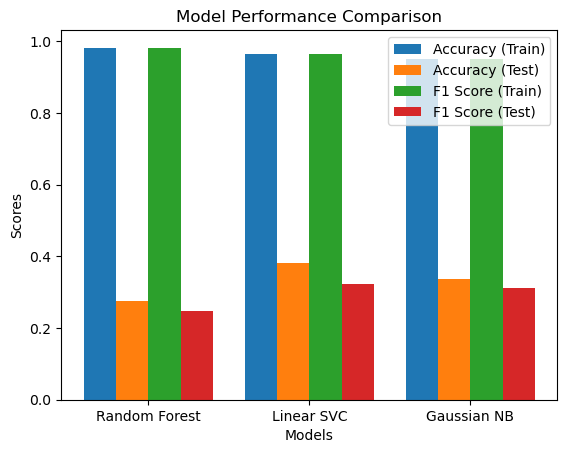

In [56]:
models = ['Random Forest', 'Linear SVC', 'Gaussian NB']
accuracy_train = [rf.score(X_train, y_train), svc.score(X_train, y_train), gnb.score(X_train, y_train)]
accuracy_test = [acc_rf, acc_svc, acc_gnb]
f1_train = [f1_score(y_train, rf.predict(X_train), average=avg), f1_score(y_train, svc.predict(X_train), average=avg), f1_score(y_train, gnb.predict(X_train), average=avg)]
f1_test = [f1_rf, f1_svc, f1_gnb]

# X-axis locations for the groups
bar_width = 0.2
index = np.arange(len(models))

# Plot
fig, ax = plt.subplots()

# Accuracy bars
acc_train_bar = ax.bar(index, accuracy_train, bar_width, label='Accuracy (Train)')
acc_test_bar = ax.bar(index + bar_width, accuracy_test, bar_width, label='Accuracy (Test)')

# F1 score bars
f1_train_bar = ax.bar(index + 2*bar_width, f1_train, bar_width, label='F1 Score (Train)')
f1_test_bar = ax.bar(index + 3*bar_width, f1_test, bar_width, label='F1 Score (Test)')

# Labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(index + bar_width + bar_width/2)
ax.set_xticklabels(models)
ax.legend()

plt.savefig('3ModelsPerf2.png')

plt.show()
